## Definitions

In [535]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from numpy import *
from qutip import *
from IPython.display import Image
from numpy.linalg import *
import multiprocessing  
from multiprocessing import Pool, cpu_count
import scipy.constants as sc
import time
import datetime
import os
from matplotlib import cm
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
plt.rcParams['figure.dpi'] = 100

saveResults = True


def find_local_maxima(data):
    """Find all local maxima in a list of values."""
    local_maxima = []
    
    # Check if the list has less than 3 elements
    if len(data) < 3:
        # In case of lists with less than 3 elements, there can't be a local maximum in the middle
        if len(data) == 1:
            return [(0, data[0])]
        if len(data) == 2:
            if data[0] > data[1]:
                return [(0, data[0])]
            if data[1] > data[0]:
                return [(1, data[1])]
        return []
    
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            local_maxima.append((i, data[i]))
    
    # Handle the boundary cases if the first or last element is a local maximum
    if data[0] > data[1]:
        local_maxima.insert(0, (0, data[0]))
    if data[-1] > data[-2]:
        local_maxima.append((len(data) - 1, data[-1]))
    
    return local_maxima

N = 4

# Operators
a = tensor(destroy(N), qeye(N), qeye(N))
b = tensor(qeye(N), destroy(N), qeye(N))
r = tensor(qeye(N), qeye(N), destroy(N))

Na = a.dag() * a
Nb = b.dag() * b
Nr = r.dag() * r
Xa = a.dag() + a
Xb = b.dag() + b
Xr = r.dag() + r
Pa = 1j * (a.dag() - a)
Pb = 1j * (b.dag() - b)
Pr = 1j * (r.dag() - r)

###############################
ls = 30.0       # Label size
fs = 30.0       # Font size
lw = 2.5        # Line width
###############################

## Time = t_1

Modes A and B are both being driven by a external field.

In [715]:
from Solver import Solver_TwoModesCoupledToMR_steadystate

# Frequencies: wa, wb, wr
w = 2 * pi * array([4.0, 4.1, 1.0]) * 1e9
wr = w[2]

# Coupling strength: ga, gb (= ga)  
#ga = 2* pi * array([10,15,20]) * 1e6
#gb = 2* pi * array([10,15,20]) * 1e6

#g = [ga,gb]

g = 2* pi * array([20,20]) * 1e6

etaA = (g[0]*g[0])/wr
etaB = (g[1]*g[1])/wr
etaAB = 2 * (g[0]*g[1])/wr 

J =  2* pi * 0 * 1e3

# Drive frequnecies: Omega_a
Omega_a_initial = w[0] - 2* pi * 1e6 * 0.9
Omega_a_final = w[0] - 2 * pi * 1e6 * 0.5

#Omega_a_initial = w[0] - 3 * (etaA)
#Omega_a_final = w[0]

Omega_a_list = linspace(Omega_a_initial, Omega_a_final, 100)

Omega = w[1] - 2 * pi * 1200 * 1e3

# Drive amplitude: Ea, Eb
E_drive = 2 * pi * array([250, 250]) * 1e3


# Dissipation rates: kappa_a, kappa_b, gamma
kappa = 2 * pi * array([50, 50, 300]) * 1e3 

# Temperatures: Ta, Tb, Tr
T = array([0, 0, 0.01])


if __name__ == '__main__':
    pool = Pool(60)
    procs = Omega_a_list
    aresults = [pool.apply_async(Solver_TwoModesCoupledToMR_steadystate, args=(N,
                                                                            w,
                                                                            g,
                                                                            J,
                                                                            E_drive,
                                                                            Omega,
                                                                            kappa,
                                                                            T,
                                                                            proc)) for proc in procs]
    
    pool.close()
    pool.join()
        
    results_at_t1 = [ar.get() for ar in aresults]




In [689]:
etaA/(2*pi*1e3), etaB/(2*pi*1e3), etaAB/(2*pi*1e3)

(400.00000000000006, 400.00000000000006, 800.0000000000001)

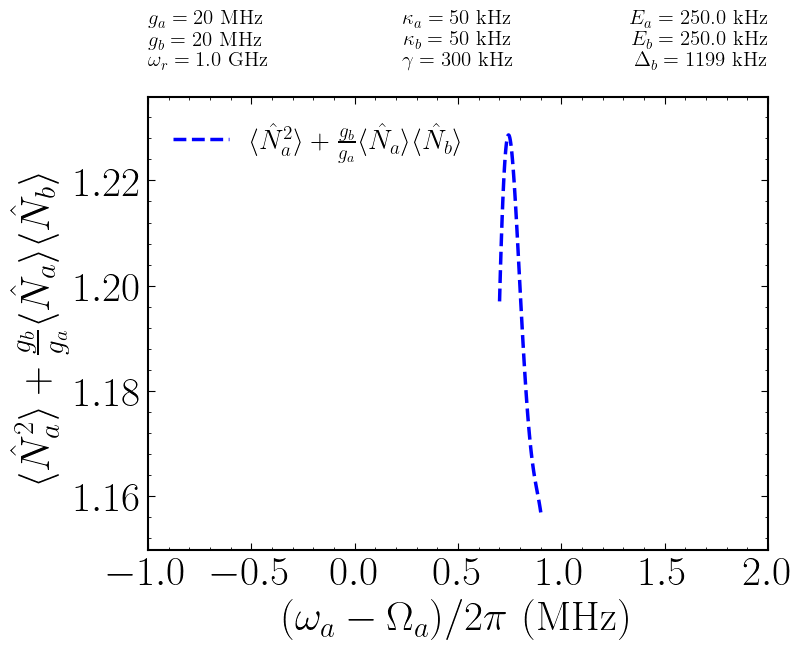

In [690]:
from scipy.signal import hilbert

# Frequency ranges
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)

# Signal amplitude
#y_list_1_t1 = [expect(Na**2, i) for i in results_at_t1]
#y_list_2_t1 = [(g[1]/g[0]) * expect(Na, i) * expect(Nb, i) for i in results_at_t1]
y_list_t1 = [expect(Na**2, i) + (g[1]/g[0]) * expect(Na, i) * expect(Nb, i) for i in results_at_t1]

# Output
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

#axes.plot(x_list, y_list_1_t1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \hat{N}_a^2 \rangle$')
#axes.plot(x_list, y_list_2_t1, color = 'b', linestyle=':', lw = lw, label = r'$\frac{g_b}{g_a} \langle \hat{N}_a\rangle \langle \hat{N}_b\rangle$')
axes.plot(x_list, y_list_t1, color = 'b', linestyle='--', lw = lw, label = r'$\langle \hat{N}_a^2 \rangle + \frac{g_b}{g_a}\langle \hat{N}_a\rangle \langle \hat{N}_b\rangle$')

#axes.vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a^2 \rangle + \frac{g_b}{g_a}\langle \hat{N}_a\rangle \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,2)
#axes.set_ylim(-0.02,1.5)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+0.001, 0.5))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.xaxis.set_minor_locator(AutoMinorLocator(5))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %.1f$ kHz \n$E_b = %.1f$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

In [691]:
find_local_maxima(y_list_t1)

[(77, 1.2286483607241847)]

In [692]:
# Peak number (from left to right)
pos = 1

# Frequency
list_pos = find_local_maxima(y_list_t1)[-pos][0]
target_pos = x_list[find_local_maxima(y_list_t1)[-pos][0]]

target_value = find_local_maxima(y_list_t1)[-pos][1]

target_pos, target_value

(0.7444444444448889, 1.2286483607241847)

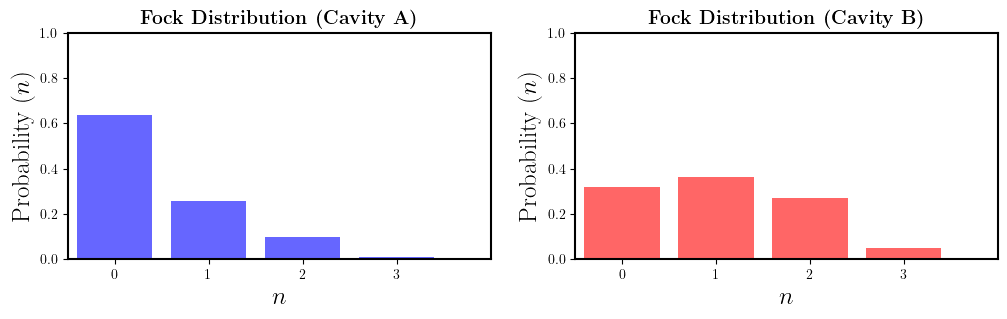

In [693]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

p = list_pos

axes[0].bar(arange(0, N), real(ptrace(results_at_t1[p],(0)).diag()), label='Cavity A' ,color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)

axes[1].bar(arange(0, N), real(ptrace(results_at_t1[p],(1)).diag()), color="red", alpha=0.6)
axes[1].set_title(r"\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

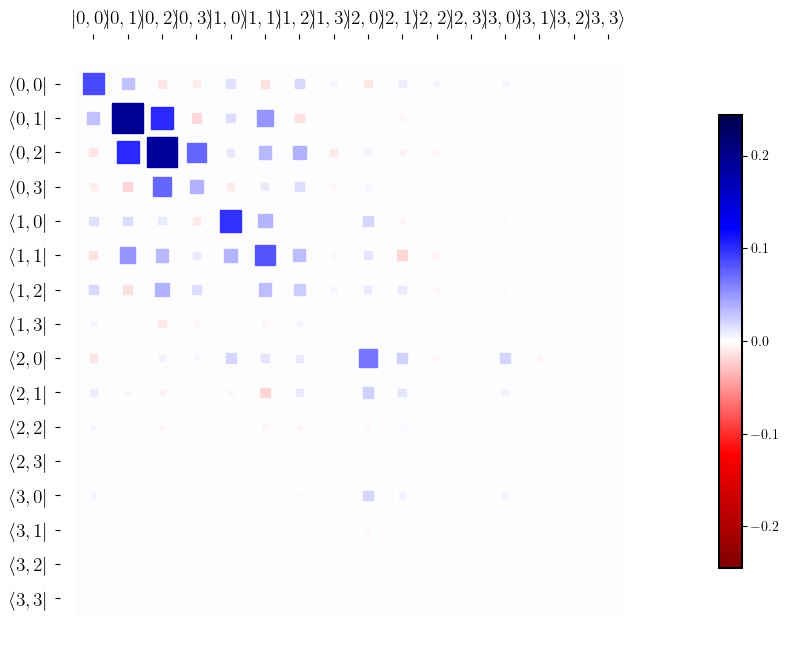

In [694]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))

hinton(ptrace(results_at_t1[p],(0,1)),ax=axes,  cmap=cm.seismic_r)

plt.show()

## Time = t_2

Mode B drive is turned off.

In [710]:
from Solver import Solver_TwoModesCoupledToMR_steadystate

# Frequencies: wa, wb, wr
w = 2 * pi * array([4.0, 4.1, 1.0]) * 1e9
wr = w[2]

# Coupling strength: ga, gb (= ga)  
#ga = 2* pi * array([10,15,20]) * 1e6
#gb = 2* pi * array([10,15,20]) * 1e6

#g = [ga,gb]

g = 2* pi * array([20,20]) * 1e6

etaA = (g[0]*g[0])/wr
etaB = (g[1]*g[1])/wr
etaAB = 2 * (g[0]*g[1])/wr 

J =  2* pi * 0 * 1e3

# Drive frequnecies: Omega_a
Omega_a_initial = w[0] - 2* pi * 1e6 * 0.9
Omega_a_final = w[0] - 2 * pi * 1e6 * 0.7

#Omega_a_initial = w[0] - 3 * (etaA)
#Omega_a_final = w[0]

Omega_a_list = linspace(Omega_a_initial, Omega_a_final, 100)

Omega = w[1] - 2 * pi * 1200 * 1e3

# Drive amplitude: Ea, Eb
E_drive = 2 * pi * array([170, 0]) * 1e3


# Dissipation rates: kappa_a, kappa_b, gamma
kappa = 2 * pi * array([50, 50, 300]) * 1e3 

# Temperatures: Ta, Tb, Tr
T = array([0, 0, 0.01])


if __name__ == '__main__':
    pool = Pool(60)
    procs = Omega_a_list
    aresults = [pool.apply_async(Solver_TwoModesCoupledToMR_steadystate, args=(N,
                                                                            w,
                                                                            g,
                                                                            J,
                                                                            E_drive,
                                                                            Omega,
                                                                            kappa,
                                                                            T,
                                                                            proc)) for proc in procs]
    
    pool.close()
    pool.join()
        
    results_at_t2 = [ar.get() for ar in aresults]




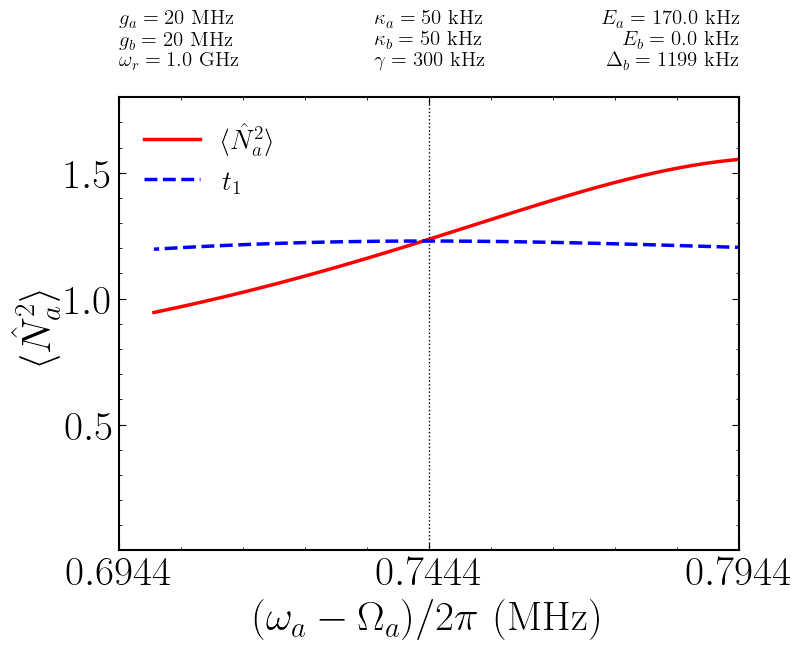

In [711]:
# Frequency ranges
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)

# Signal amplitude
y_list_t2 = [expect(Na**2, i) for i in results_at_t2]
#y_list_2_t1 = [(g[1]/g[0]) * expect(Na, i) * expect(Nb, i) for i in results_at_t1]
#y_list_t2 = [expect(Na**2, i) + (g[1]/g[0]) * expect(Na, i) * expect(Nb, i) for i in results_at_t1]

# Output
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

#axes.plot(x_list, y_list_1_t1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \hat{N}_a^2 \rangle$')
#axes.plot(x_list, y_list_2_t1, color = 'b', linestyle=':', lw = lw, label = r'$\frac{g_b}{g_a} \langle \hat{N}_a\rangle \langle \hat{N}_b\rangle$')
axes.plot(x_list, y_list_t2, color = 'r', linestyle='-', lw = lw, label = r'$\langle \hat{N}_a^2 \rangle$')
axes.plot(x_list, y_list_t1, color = 'b', linestyle='--', lw = lw, label = r'$t_1$')

axes.vlines(target_pos, -1, 2, color='black', linestyle=':', lw = 1)
#axes.vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a^2 \rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(target_pos-0.05,target_pos+0.05)
axes.set_ylim(0.001,1.8)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+0.001, 0.05))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.xaxis.set_minor_locator(AutoMinorLocator(5))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %.1f$ kHz \n$E_b = %.1f$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

In [712]:
# Peak number (from left to right)
#pos = 2

# Frequency
#obtained_pos = x_list[find_local_maxima(y_list_t2)[-pos][0]]

#obtained_value = find_local_maxima(y_list_t2)[-pos][1]

obtained_value = y_list_t2[list_pos]

prec = 0.01
dif = obtained_value - target_value
if(dif > prec):
    print('Error. Dif = %f is bigger than Prec = %f. Choose a smaller value for E_a at t_2' % (dif, prec))
elif(dif < -prec):
    print('Error. Dif = %f is smaller than Prec = -%f. Choose a higher value for E_a at t_2' % (dif, prec))
else:
    print('Success. Dif = %f. E_a = %f at t_2' % (dif, (E_drive[0]/(2*pi*1e3))))
    

Success. Dif = 0.007815. E_a = 170.000000 at t_2


## Results for t_1 and t_2

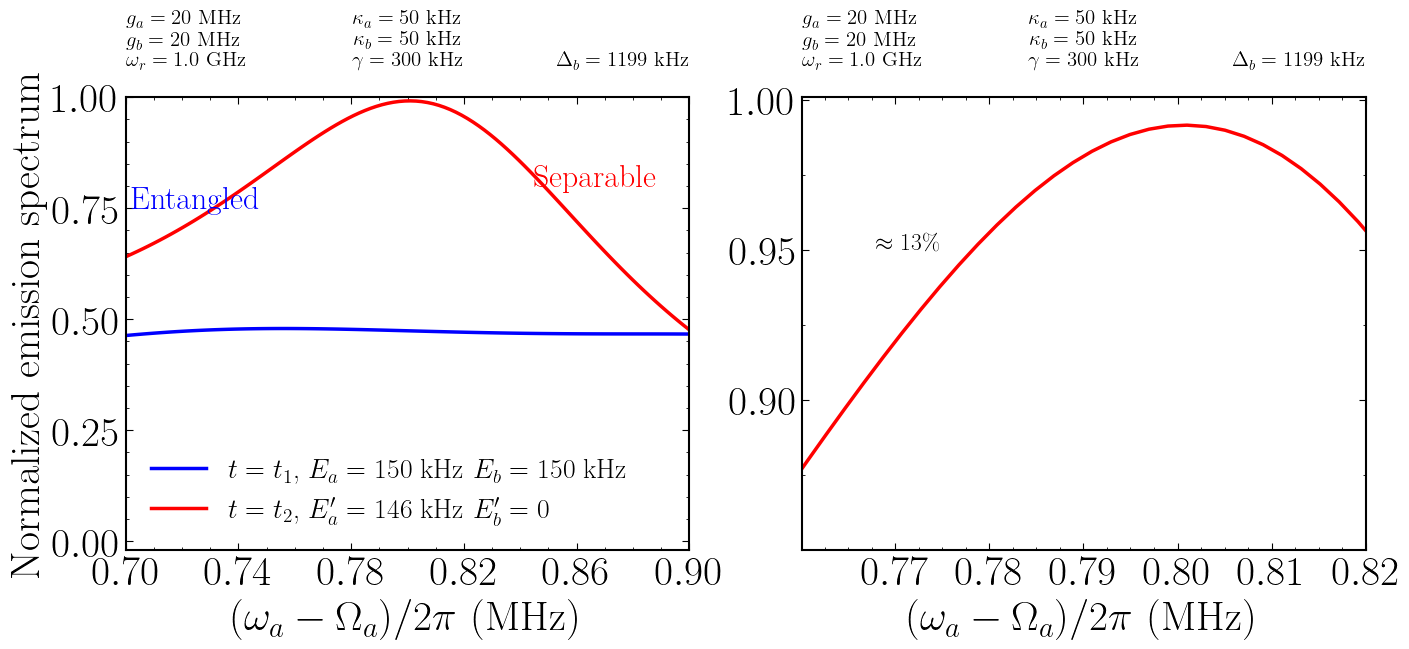

In [714]:
from scipy.signal import hilbert

x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)

# Signal amplitude
y_list_1 = [expect(Na, i) for i in results_at_t1]
y_list_2 = [expect(Na, i) for i in results_at_t2]

# Signal phase
y_list_1_phase = hilbert(angle(y_list_1))
y_list_2_phase = hilbert(angle(y_list_2))

# Normalization
#y_list_1 = [i/max(y_list_1) for i in y_list_1]
#y_list_2 = [i/max(y_list_2) for i in y_list_2]


# Output
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(x_list, y_list_1, color = 'blue', linestyle='-', lw = lw, label = r'$t = t_1$, $E_a = 150$ kHz $E_b = 150$ kHz')
axes[0].plot(x_list, y_list_2, color = 'red', linestyle='-', lw = lw, label = r'$t = t_2$, $E^\prime_a = 146$ kHz $E^\prime_b = 0$')

axes[0].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'Normalized emission spectrum', rotation=90, fontsize=fs)

axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks_position('both')
axes[0].legend(loc=3, fontsize=floor(fs/1.5), frameon=False)

axes[0].set_xlim(0.7,0.9)
axes[0].set_ylim(-0.02, 1.00)

start, end = axes[0].get_xlim()
axes[0].xaxis.set_ticks(arange(start, end+0.0001, 0.04))

axes[0].xaxis.set_ticks_position('both')
axes[0].yaxis.set_ticks_position('both')

axes[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[0].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[0].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[0].margins(x=0.1, y=0.1)
##############################
axes[1].plot(x_list, y_list_1, color = 'blue', linestyle='-', lw = lw, label = r'$t = t_1$ (entangled)')
axes[1].plot(x_list, y_list_2, color = 'red', linestyle='-', lw = lw, label = r'$t = t_2$ (separable)')

axes[1].vlines(x_list[list_pos],-2,2, color='black', linestyle=':', lw = 1)
axes[1].hlines(y_list_2[list_pos],-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes[1].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\langle \hat{N}_a^2\rangle , \langle \hat{N}_b^2\rangle$', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
#axes[1].legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes[1].set_xlim(0.7601,0.830)
axes[1].set_ylim(0.9,1.001)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(0.760, end+0.001, (end - 0.760)/7))

axes[1].set_xlim(0.7601,0.820)
axes[1].set_ylim(0.85001,1.001)

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[1].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[1].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[1].arrow(x_list[list_pos],y_list_1[list_pos]-0.001,0,y_list_2[list_pos]-y_list_1[list_pos]+0.006, width = 0.00007, head_width=0.001, head_length=0.003, color='black')

axes[0].text(0.702,0.75,r'Entangled', color='blue',fontsize=23)
axes[0].text(0.845,0.8,r'Separable', color='red',fontsize=23)

axes[1].text(0.768, 0.95,r'$\approx 13\%$', fontsize=17)

axes[1].margins(x=0.1, y=0.1)


#plt.savefig("Results/result7.pdf", bbox_inches='tight')
#plt.savefig("Results/result7.png", bbox_inches='tight')

plt.show()

In [684]:
(y_list_1[list_pos] - y_list_2[list_pos]) * 100

12.925098304370275

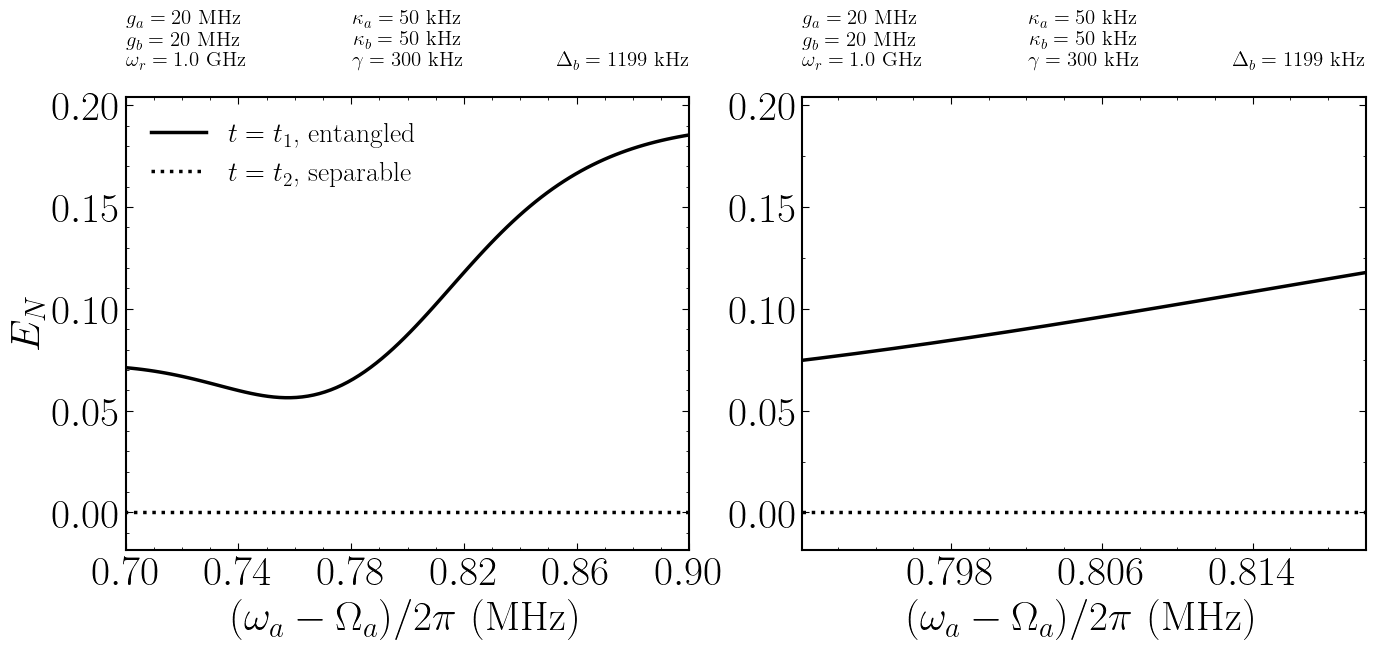

In [526]:
from scipy.signal import hilbert

x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)

y_list_1_neg = [negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=True) for i in results_at_t1]
y_list_2_neg = [negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=True) for i in results_at_t2]

# Output
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(x_list, y_list_1_neg, color = 'black', linestyle='-', lw = lw, label = r'$t = t_1$, entangled')
axes[0].plot(x_list, y_list_2_neg, color = 'black', linestyle=':', lw = lw, label = r'$t = t_2$, separable')

axes[0].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'$E_N$', rotation=90, fontsize=fs)

axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks_position('both')
axes[0].legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes[0].set_xlim(0.7,0.9)
#axes[0].set_ylim(-0.02, 1.00)

start, end = axes[0].get_xlim()
axes[0].xaxis.set_ticks(arange(start, end+0.0001, 0.04))

axes[0].xaxis.set_ticks_position('both')
axes[0].yaxis.set_ticks_position('both')

axes[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[0].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[0].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[0].margins(x=0.1, y=0.1)
##############################
axes[1].plot(x_list, y_list_1_neg, color = 'black', linestyle='-', lw = lw, label = r'$t = t_1$ (entangled)')
axes[1].plot(x_list, y_list_2_neg, color = 'black', linestyle=':', lw = lw, label = r'$t = t_2$ (separable)')

#axes[1].vlines(x_list[list_pos],-2,2, color='black', linestyle=':', lw = 1)
#axes[1].hlines(y_list_2[list_pos],-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes[1].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\langle \hat{N}_a^2\rangle , \langle \hat{N}_b^2\rangle$', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
#axes[1].legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes[1].set_xlim(0.7801,0.830)
#axes[1].set_ylim(0.85,1.001)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(0.790, end+0.001, (end - 0.790)/5))

axes[1].set_xlim(0.7901,0.820)

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[1].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[1].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

#axes[1].arrow(x_list[list_pos],y_list_1[list_pos],0,y_list_2[list_pos]-y_list_1[list_pos]+0.005, width = 0.00007, head_width=0.0005, head_length=0.005, color='black')

#axes[0].text(0.71,0.8,r'Entangled', color='blue',fontsize=23)
#axes[0].text(0.845,0.8,r'Separable', color='red',fontsize=23)

#axes[1].text(0.796, 0.96,r'$\approx 10\%$', fontsize=18)

axes[1].margins(x=0.1, y=0.1)

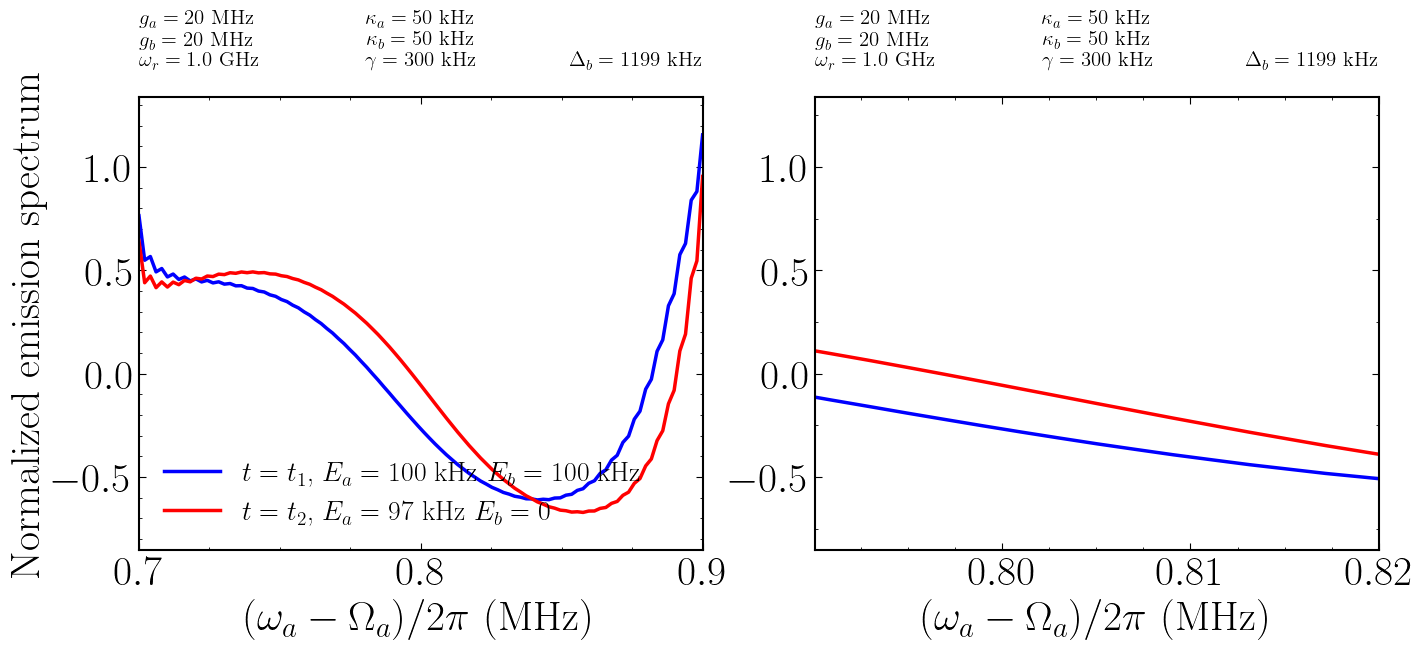

In [452]:
from scipy.signal import hilbert

x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)

# Signal phase
y_list_1_phase = angle(hilbert(y_list_1))
y_list_2_phase = angle(hilbert(y_list_2))

# Normalization
#y_list_1 = [i/max(y_list_1) for i in y_list_1]
#y_list_2 = [i/max(y_list_2) for i in y_list_2]

# Output
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(x_list, y_list_1_phase, color = 'blue', linestyle='-', lw = lw, label = r'$t = t_1$, $E_a = 100$ kHz $E_b = 100$ kHz')
axes[0].plot(x_list, y_list_2_phase, color = 'red', linestyle='-', lw = lw, label = r'$t = t_2$, $E_a = 97$ kHz $E_b = 0$')

axes[0].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'Normalized emission spectrum', rotation=90, fontsize=fs)

axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks_position('both')
axes[0].legend(loc=3, fontsize=floor(fs/1.5), frameon=False)

axes[0].set_xlim(0.7,0.9)
#axes[0].set_ylim(-0.02, 1.00)

#start, end = axes[0].get_xlim()
#axes[0].xaxis.set_ticks(arange(start, end+0.0001, 0.04))

axes[0].xaxis.set_ticks_position('both')
axes[0].yaxis.set_ticks_position('both')

axes[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[0].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[0].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[0].margins(x=0.1, y=0.1)
##############################
axes[1].plot(x_list, y_list_1_phase, color = 'blue', linestyle='-', lw = lw, label = r'$t = t_1$ (entangled)')
axes[1].plot(x_list, y_list_2_phase, color = 'red', linestyle='-', lw = lw, label = r'$t = t_2$ (separable)')

#axes[1].vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes[1].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\langle \hat{N}_a^2\rangle , \langle \hat{N}_b^2\rangle$', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[1].yaxis.set_ticks_position('both')
#axes[1].legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes[1].set_xlim(0.7901,0.820)
#axes[1].set_ylim(0.9,1)

#start, end = axes[1].get_xlim()
#axes[1].xaxis.set_ticks(arange(0.790, end+0.001, (end - 0.790)/5))

#axes[1].set_xlim(0.7901,0.820)

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[1].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[1].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[1].margins(x=0.1, y=0.1)

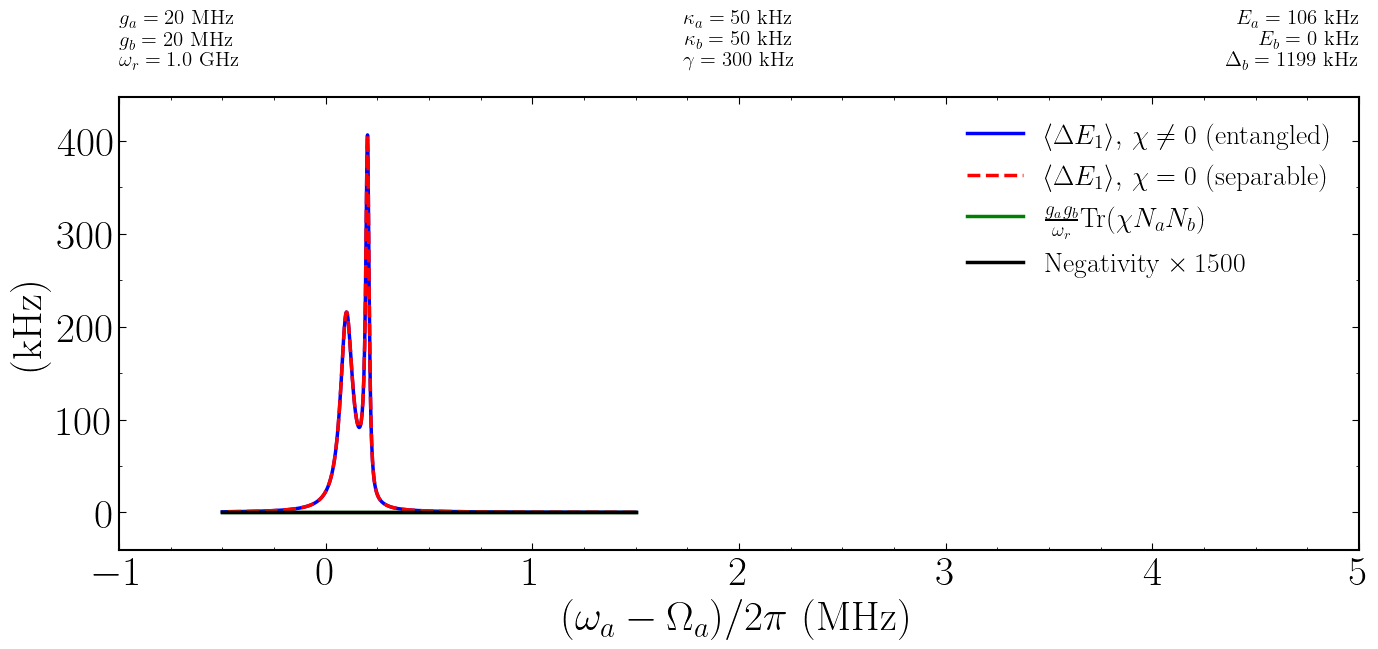

In [321]:
x_list = (w[0] - Omega_a_list) / (2*pi*1e6)
y_list_1 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i) + etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_2 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i))/(2*pi*1e3) for i in results]
y_list_3 = [(etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_4 = [1500*negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=False) for i in results]
#y_list_5 = [100*(1 - ((expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2))) for i in results]
#y_list_6 = [800*(1 - ((ptrace(i,(0)))**2).tr()) for i in results]

y_list_3 = y_list_3 + abs(min(y_list_3))

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi \neq 0$ (entangled)')
axes.plot(x_list, y_list_2, color = 'r', linestyle='--', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi = 0$ (separable)')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = r'$\frac{g_a g_b}{\omega_r}$Tr$(\chi N_a N_b)$')
axes.plot(x_list, y_list_4, color = 'black', linestyle='-', lw = lw, label = r'Negativity $\times\,1500$')
#axes.plot(x_list, y_list_5, color = 'yellow', linestyle='-', lw = lw, label = r'$100\times(1-g^2(0))$')
#axes.plot(x_list, y_list_6, color = 'orange', linestyle='-', lw = lw, label = r'Linear entropy $\times\,1000$')

#axes.vlines(etaA/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + 2*etaAB)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)
#axes.vlines((3*etaA)/(2*pi*1e6),-1,800, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'(kHz)', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=1, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
#axes.set_ylim(-0.02,800)


start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1000,)

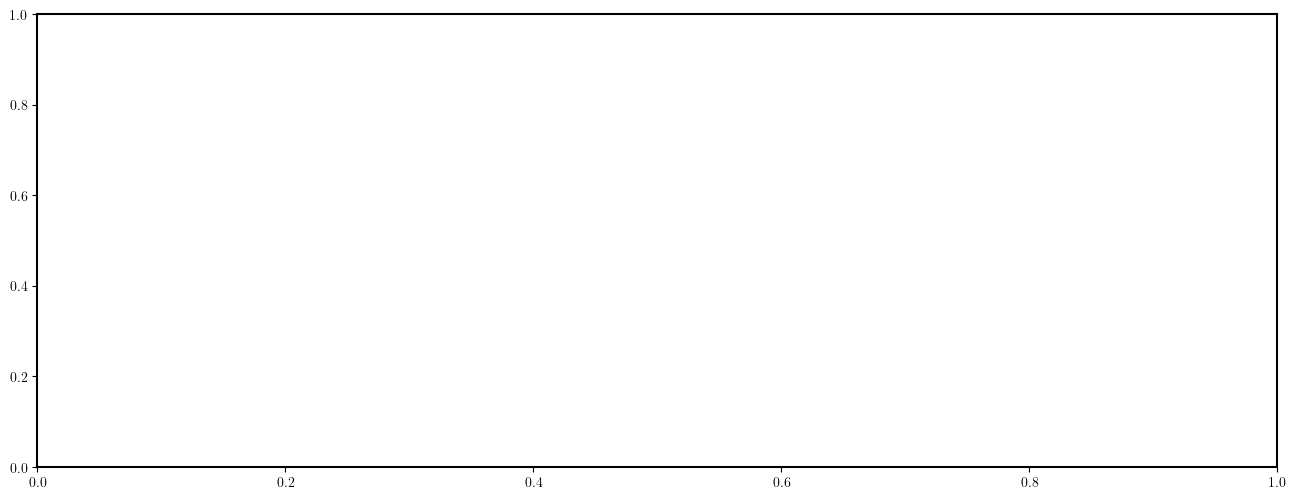

In [379]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i) + etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_2 = [abs(etaA * expect(Na**2, i) + etaAB * expect(Na, i) * expect(Nb, i))/(2*pi*1e3) for i in results]
y_list_3 = [(etaAB * expect(Na * Nb, i - tensor(ptrace(i, (0)), ptrace(i, (1)), ptrace(i, (2)))))/(2*pi*1e3) for i in results]
y_list_4 = [1500*negativity(ptrace(i,(0,1)), 0, method='eigenvalues', logarithmic=True) for i in results]
#y_list_5 = [100*(1 - ((expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2))) for i in results]
#y_list_6 = [800*(1 - ((ptrace(i,(0)))**2).tr()) for i in results]

y_list_3 = y_list_3 + abs(min(y_list_3))

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi \neq 0$ (entangled)')
axes.plot(x_list, y_list_2, color = 'r', linestyle='--', lw = lw, label = r'$\langle \Delta E_1 \rangle,\,\chi = 0$ (separable)')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = r'$\frac{g_a g_b}{\omega_r}$Tr$(\chi N_a N_b)$')
axes.plot(x_list, y_list_4, color = 'black', linestyle='-', lw = lw, label = r'Negativity $\times\,2000$')
#axes.plot(x_list, y_list_5, color = 'yellow', linestyle='-', lw = lw, label = r'$100\times(1-g^2(0))$')
#axes.plot(x_list, y_list_6, color = 'orange', linestyle='-', lw = lw, label = r'Linear entropy $\times\,1000$')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a $', rotation=0, fontsize=fs)
axes.set_ylabel(r'(kHz)', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,800)


start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

In [24]:
Omega_a_initial_ = w[0] - 3 * (etaA)
Omega_a_final_ = w[0]

Omega_a_list_ = linspace(Omega_a_initial_, Omega_a_final_, 1000)

x_list_ = (w[0] - Omega_a_list_) / (2 * pi * 1e6)
y_list_1 = [expect(Na, i) for i in results_at_t1]
y_list_2 = [expect(Na, i) for i in results_at_t2]

y_list_1 = [i/max(y_list_1) for i in y_list_1]
y_list_2 = [i/max(y_list_2) for i in y_list_2]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(x_list_, y_list_1, color = 'b', linestyle='-', lw = lw, label = '$t = t_2$, $E_a = %d$ kHz, $E_b = %d$ kHz ' % (100, 80))
axes[0].plot(x_list_, y_list_2, color = 'r', linestyle='-', lw = lw, label = '$t = t_2$, $E_a = %d$ kHz, $E_b = %d$ kHz ' % (98, 0))

#axes[0].vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[0].vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[0].vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes[0].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes[0].set_ylabel(r'Normalized emission spectrum', rotation=90, fontsize=fs-5)

axes[0].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[0].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes[0].yaxis.set_ticks_position('both')
axes[0].legend(loc=3, fontsize=floor(fs/1.5), frameon=False)

axes[0].set_xlim(0.7,0.9)
axes[0].set_ylim(-0.02,1)

start, end = axes[0].get_xlim()
axes[0].xaxis.set_ticks(arange(start, end+0.0001, 0.04))

axes[0].xaxis.set_ticks_position('both')
axes[0].yaxis.set_ticks_position('both')

axes[0].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[0].xaxis.set_tick_params(length=5)
axes[0].yaxis.set_tick_params(length=5)

axes[0].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[0].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[0].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[0].margins(x=0.1, y=0.1)

####################

axes[1].plot(1000 * x_list_, y_list_1, color = 'b', linestyle='-', lw = lw, label = '$t = t_1$, $E_a = %d$ kHz, $E_b = %d$ kHz ' % (100, 80))
axes[1].plot(1000 * x_list_, y_list_2, color = 'r', linestyle='-', lw = lw, label = '$t = t_2$, $E_a = %d$ kHz, $E_b = %d$ kHz ' % (98, 0))

#axes[1].vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes[1].vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes[1].set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (kHz)', rotation=0, fontsize=fs)
#axes[1].set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes[1].tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes[1].tick_params(axis='both', which='minor', direction='in', labelsize=ls)
#axes[1].legend(loc=3, fontsize=floor(fs/1.5), frameon=False)

axes[1].set_xlim(790,820)
axes[1].set_ylim(0.9,1)

start, end = axes[1].get_xlim()
axes[1].xaxis.set_ticks(arange(start, end+0.001, 6))

axes[1].xaxis.set_ticks_position('both')
axes[1].yaxis.set_ticks_position('both')

axes[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axes[1].xaxis.set_minor_locator(AutoMinorLocator(4))

axes[1].xaxis.set_tick_params(length=5)
axes[1].yaxis.set_tick_params(length=5)

axes[1].set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes[1].set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes[1].set_title('$\Delta_b = %d$ kHz' % (((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes[1].margins(x=0.1, y=0.1)



NameError: name 'results_at_t1' is not defined

In [ ]:
find_local_maxima(y_list_1)

[(0, 0.12179298838373273), (332, 1.0), (654, 0.8034938340195863)]

In [ ]:
find_local_maxima(y_list_2)

[(325, 1.0), (664, 0.7638636630162337)]

In [ ]:
shift = x_list_[332] - x_list_[325]
shift * 1000

-8.408408408507206

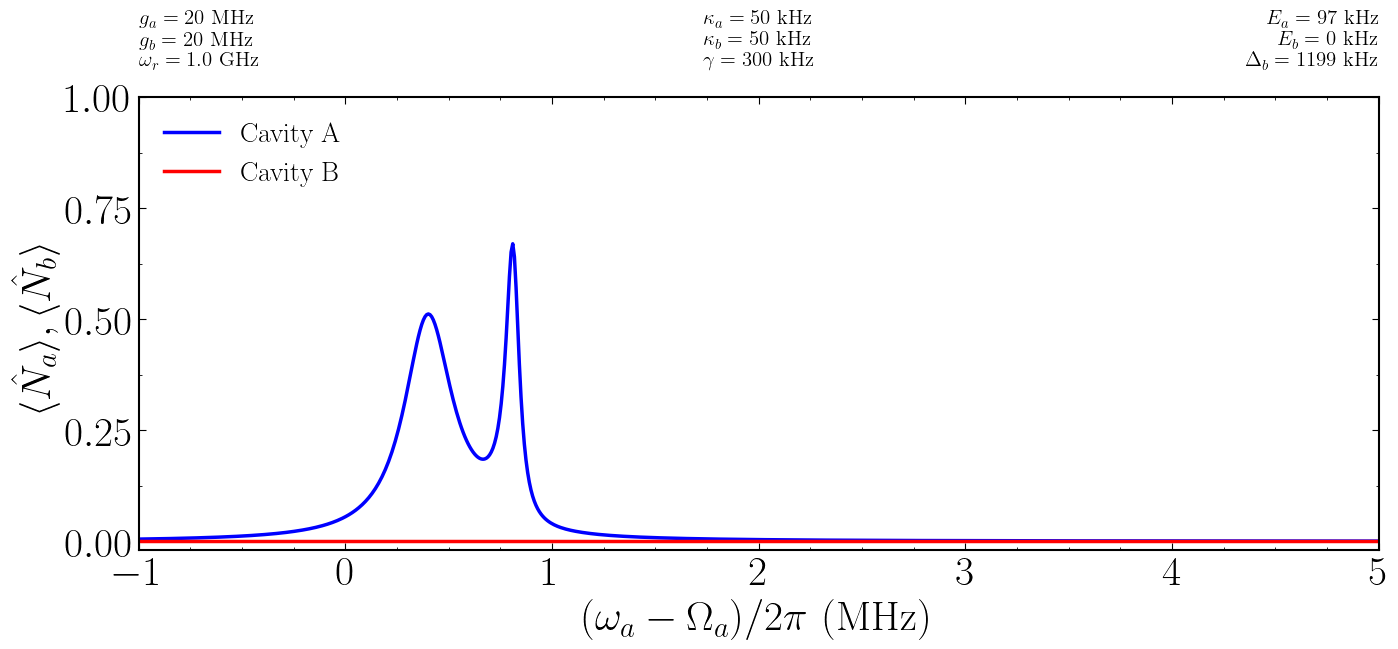

In [ ]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Na, i) for i in results]
y_list_2 = [expect(Nb, i) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')

#axes.vlines(etaA/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)
#axes.vlines((etaA + etaAB)/(2*pi*1e6),-1,1, color='black', linestyle=':', lw = 1)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,1)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

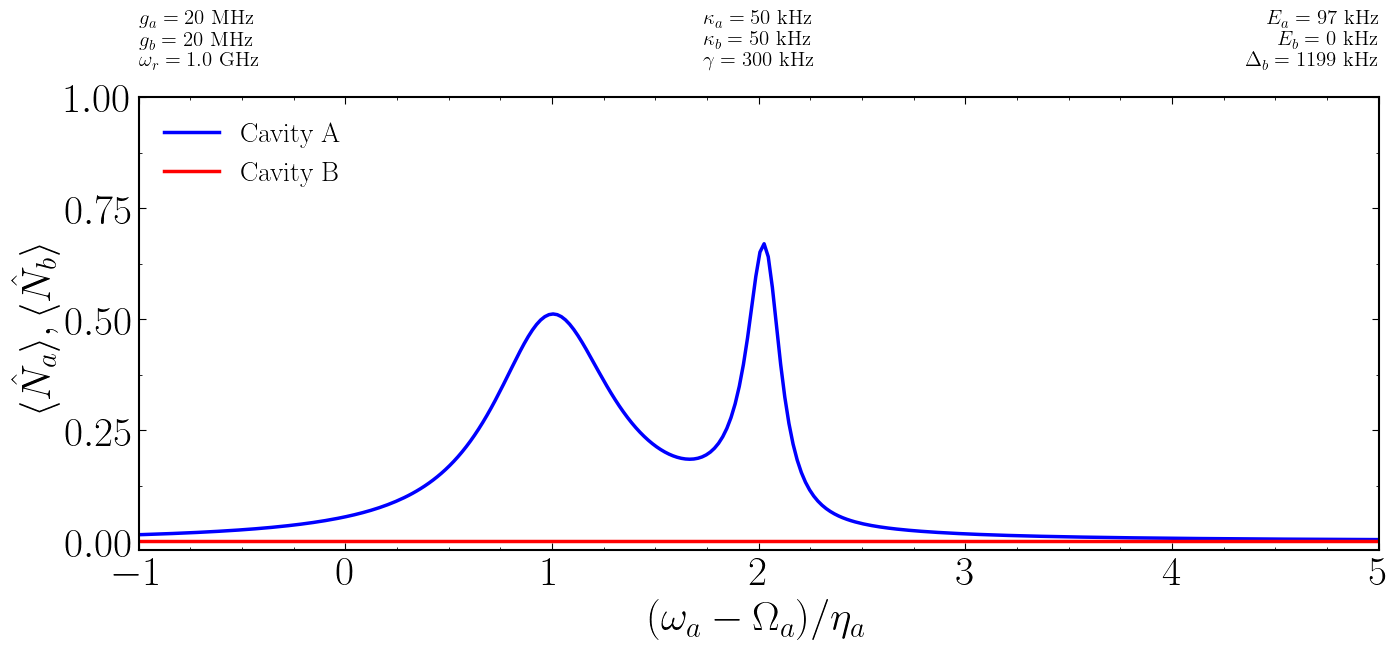

In [ ]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [expect(Na, i) for i in results]
y_list_2 = [expect(Nb, i) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a$', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
axes.set_ylim(-0.02,1)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

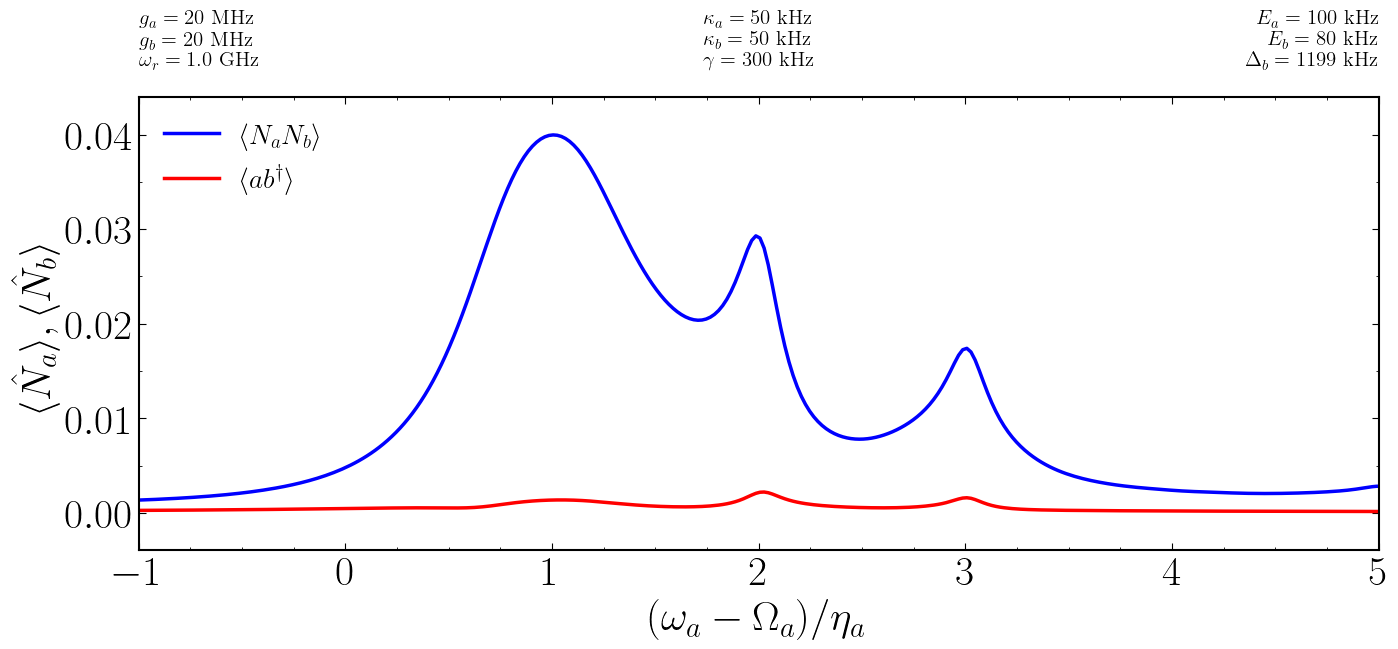

In [ ]:
x_list = (w[0] - Omega_a_list) / (etaA)
#y_list_1 = [expect(Na * Nb, i) for i in results]
#y_list_2 = [abs(expect(a * b.dag(), i))**2 for i in results]

y_list_1 = [sqrt(expect(Na * Nb * Nr, i)) for i in results]
y_list_2 = [abs(expect(a * b.dag() * r.dag(), i)) for i in results]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = r'$\langle N_a N_b \rangle$')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = r'$\langle a b^\dagger \rangle$')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a$', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle \hat{N}_a\rangle , \langle \hat{N}_b\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')
axes.legend(loc=2, fontsize=floor(fs/1.5), frameon=False)

axes.set_xlim(-1,5)
#axes.set_ylim(-0.02,0.01)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

In [ ]:
rhoAB = ptrace(results[698],(0,1))
rhoAB

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.50394006+0.j         0.        +0.j         0.        +0.j
  0.12300455-0.06188769j 0.        +0.j         0.        +0.j
  0.00061866-0.0211619j  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.12300455+0.06188769j 0.        +0.j         0.        +0.j
  0.48183342+0.j         0.        +0.j         0.        +0.j
  0.00513615-0.08157427j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0

In [ ]:
rhoATB = partial_transpose(rhoAB,(0,1))

In [ ]:
rhoAB.eigenenergies()

array([-2.15827917e-17, -1.96343997e-51,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.49311353e-20,  1.50421378e-04,  3.60910179e-01,
        6.38939400e-01])

In [ ]:
rhoATB.eigenenergies()

array([-2.15827917e-17, -1.96343997e-51,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.49311353e-20,  1.50421378e-04,  3.60910179e-01,
        6.38939400e-01])

In [ ]:
rho = results[698] 
(rho - tensor(ptrace(rho, (0)), ptrace(rho, (1)), ptrace(rho, (2))))

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[ 9.01525358e-05+0.00000000e+00j -5.05636892e-03+9.95321857e-07j
  -7.48459754e-05+2.59968319e-08j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.24266937e-05-2.92506406e-05j
   1.20568203e-03-6.08042072e-04j  1.62292183e-05-8.19408498e-06j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.73537731e-06-6.83491589e-06j  1.79568154e-05-6.27583641e-04j
   5.83989345e-07-2.06015413e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-

In [ ]:
chiAB = (rho - tensor(ptrace(rho, (0)), ptrace(rho, (1)), ptrace(rho, (2))))

In [ ]:
sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1])

D:\Users\asantana\AppData\Local\Temp\2\ipykernel_20456\4127831239.py:1: RuntimeWarning: invalid value encountered in sqrt
  sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1])


array([           nan,            nan,            nan,            nan,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.19210277e-30, 6.34169642e-30,
       2.24847461e-22, 7.00150059e-14, 2.00421239e-13, 1.17915609e-11,
       6.15639443e-11, 4.89957587e-06, 4.93692709e-06, 1.23574522e-05,
       2.17997102e-05, 2.82475530e-05, 3.70722459e-03, 3.77392016e-03,
       6.58736291e-03])

In [ ]:
sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[2:-1]))

D:\Users\asantana\AppData\Local\Temp\2\ipykernel_20456\3714146798.py:1: RuntimeWarning: invalid value encountered in sqrt
  sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[2:-1]))


nan

In [ ]:
sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1]))

D:\Users\asantana\AppData\Local\Temp\2\ipykernel_20456\1097125578.py:1: RuntimeWarning: invalid value encountered in sqrt
  sum(sqrt((chiAB * chiAB.dag()).eigenenergies()[1:-1]))


nan

In [ ]:
def find_local_maxima(data):
    """Find all local maxima in a list of values."""
    local_maxima = []
    
    # Check if the list has less than 3 elements
    if len(data) < 3:
        # In case of lists with less than 3 elements, there can't be a local maximum in the middle
        if len(data) == 1:
            return [(0, data[0])]
        if len(data) == 2:
            if data[0] > data[1]:
                return [(0, data[0])]
            if data[1] > data[0]:
                return [(1, data[1])]
        return []
    
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            local_maxima.append((i, data[i]))
    
    # Handle the boundary cases if the first or last element is a local maximum
    if data[0] > data[1]:
        local_maxima.insert(0, (0, data[0]))
    if data[-1] > data[-2]:
        local_maxima.append((len(data) - 1, data[-1]))
    
    return local_maxima

In [ ]:
find_local_maxima(y_list_1)

[(648, 0.6699316583045376), (699, 0.5118498237042712)]

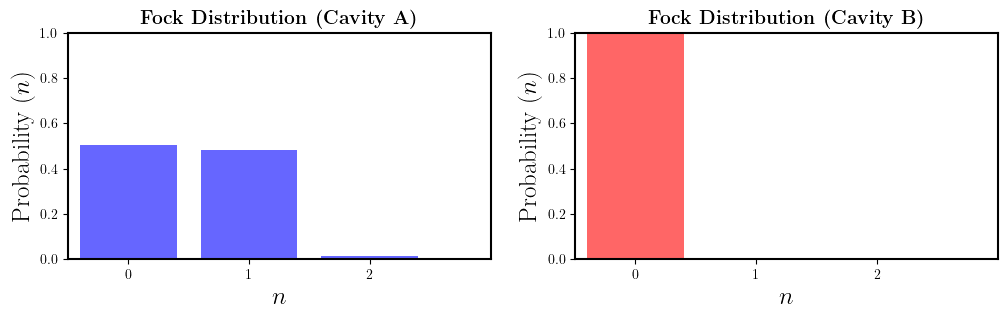

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

p = 698

axes[0].bar(arange(0, N), real(ptrace(results[p],(0)).diag()), label='Cavity A' ,color="blue", alpha=0.6)
axes[0].set_title("\\textbf{Fock Distribution (Cavity A)}",fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(-0.5, N)
axes[0].set_xticks(arange(0, N))
axes[0].set_xlabel(r'$n$', fontsize=18)
axes[0].set_ylabel(r'Probability ($n$)', fontsize=18)

axes[1].bar(arange(0, N), real(ptrace(results[p],(1)).diag()), color="red", alpha=0.6)
axes[1].set_title(r"\textbf{Fock Distribution (Cavity B)}",fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].set_xlim(-0.5, N)
axes[1].set_xticks(arange(0, N))
axes[1].set_xlabel(r'$n$', fontsize=18)
axes[1].set_ylabel(r'Probability ($n$)', fontsize=18)

plt.show()

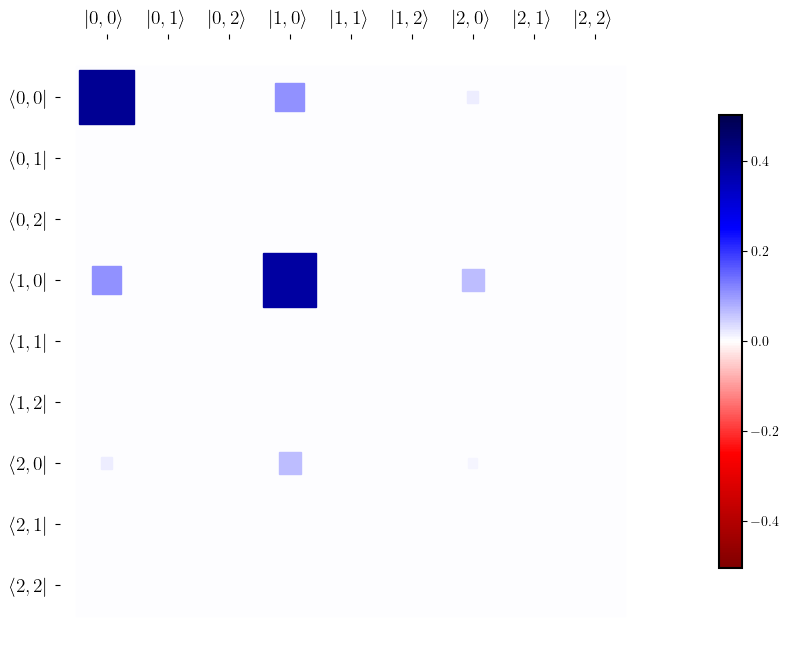

In [ ]:
#hinton(ptrace(results[p],(0,1))) # xlabels=xlabels, ylabels=xlabels)

fig, axes = plt.subplots(1, 1, figsize=(10,8))

hinton(ptrace(results[p],(0,1)),ax=axes,  cmap=cm.seismic_r)

plt.show()

NameError: name 'p' is not defined

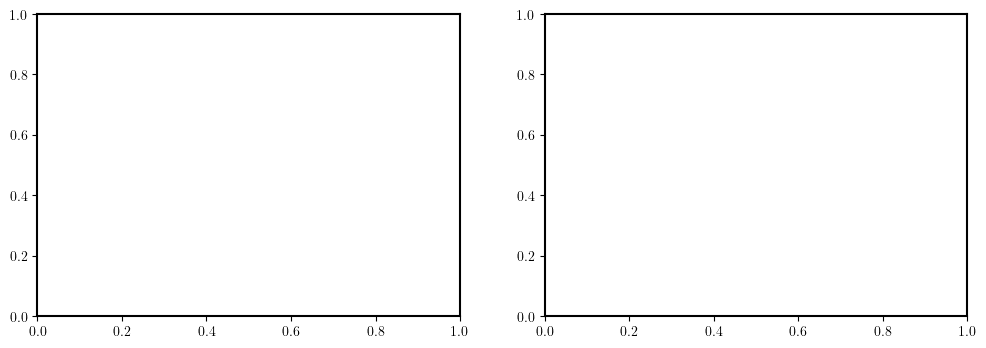

In [378]:
#hinton(ptrace(results[p],(0,1))) # xlabels=xlabels, ylabels=xlabels)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

hinton(ptrace(results_at_t1[p],(0)),ax=axes[0],  cmap=cm.seismic_r)
hinton(ptrace(results_at_t1[p],(1)),ax=axes[1],  cmap=cm.seismic_r)

plt.show()

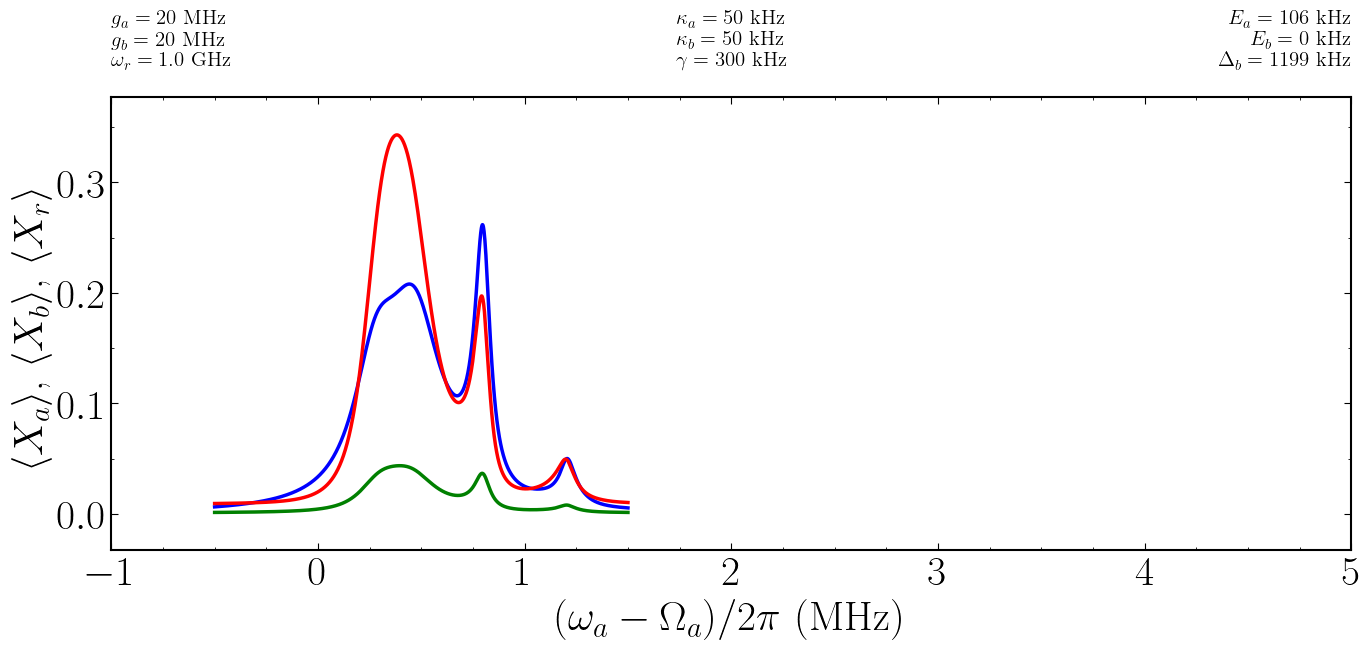

In [377]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Xa, i)  for i in results_at_t1]
y_list_2 = [expect(Xb, i)  for i in results_at_t1]
y_list_3 = [expect(Xr, i)  for i in results_at_t1]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = 'Mechanical Resonator')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle X_a\rangle$, $\langle X_b\rangle$, $\langle X_r\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
#axes.set_ylim(-0.01,0.11)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

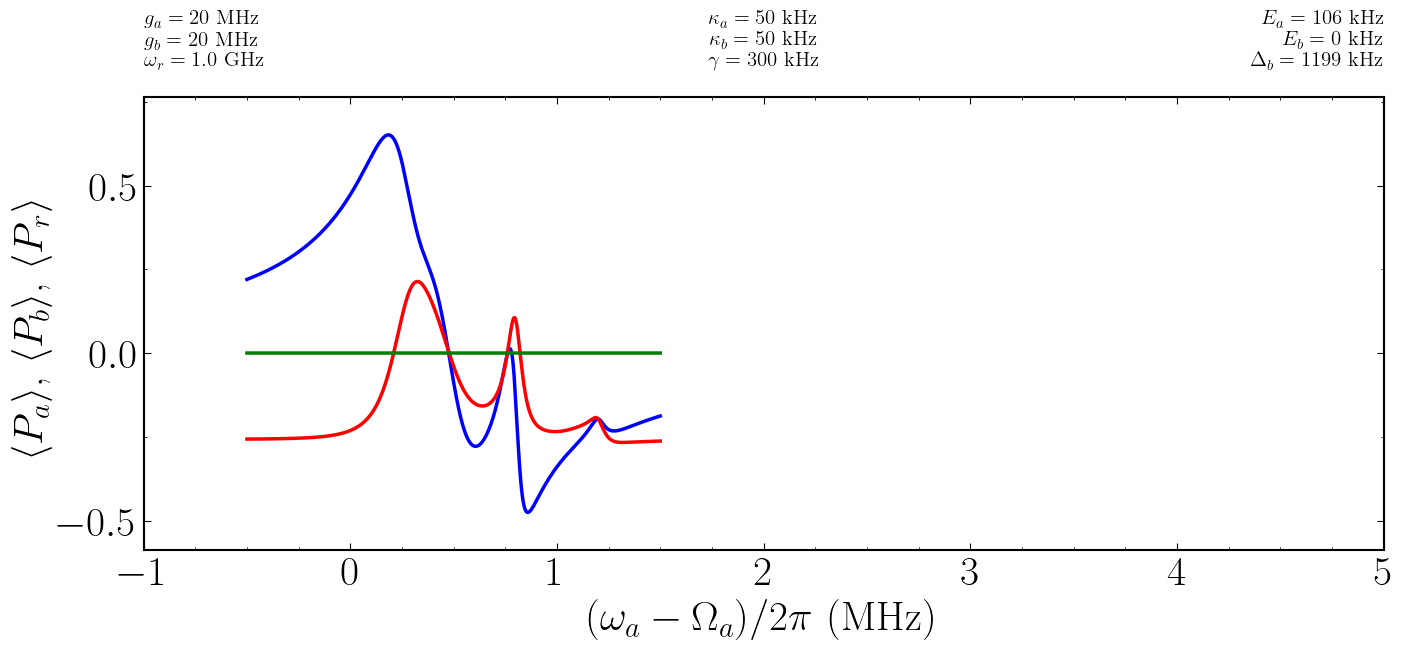

In [376]:
x_list = (w[0] - Omega_a_list) / (2 * pi * 1e6)
y_list_1 = [expect(Pa, i)  for i in results_at_t1]
y_list_2 = [expect(Pb, i)  for i in results_at_t1]
y_list_3 = [expect(Pr, i)  for i in results_at_t1]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'b', linestyle='-', lw = lw, label = 'Cavity A')
axes.plot(x_list, y_list_2, color = 'r', linestyle='-', lw = lw, label = 'Cavity B')
axes.plot(x_list, y_list_3, color = 'g', linestyle='-', lw = lw, label = 'Mechanical Resonator')

axes.set_xlabel(r'$(\omega_a - \Omega_a)/2\pi$ (MHz)', rotation=0, fontsize=fs)
axes.set_ylabel(r'$\langle P_a\rangle$, $\langle P_b\rangle$, $\langle P_r\rangle$', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
#axes.set_ylim(-0.01,0.11)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.set_title('$g_a = %d$ MHz \n$g_b = %d$ MHz \n$\omega_r = %.1f$ GHz' % ((g[0]/(2*pi*1e6)), (g[1]/(2*pi*1e6)), (w[2]/(2*pi*1e9))), loc = 'left', y = 1.05, fontsize = 15)
axes.set_title('$\kappa_a = %d$ kHz \n$\kappa_b = %d$ kHz \n$\gamma = %d$ kHz' % ((kappa[0]/(2*pi*1e3)), (kappa[1]/(2*pi*1e3)), (kappa[2]/(2*pi*1e3))), loc = 'center', y = 1.05, fontsize = 15)
axes.set_title('$E_a = %d$ kHz \n$E_b = %d$ kHz \n$\Delta_b = %d$ kHz' % ((E_drive[0]/(2*pi*1e3)), (E_drive[1]/(2*pi*1e3)), ((w[1] - Omega)/(2*pi*1e3))), loc = 'right', y = 1.05, fontsize = 15)

axes.margins(x=0.1, y=0.1)

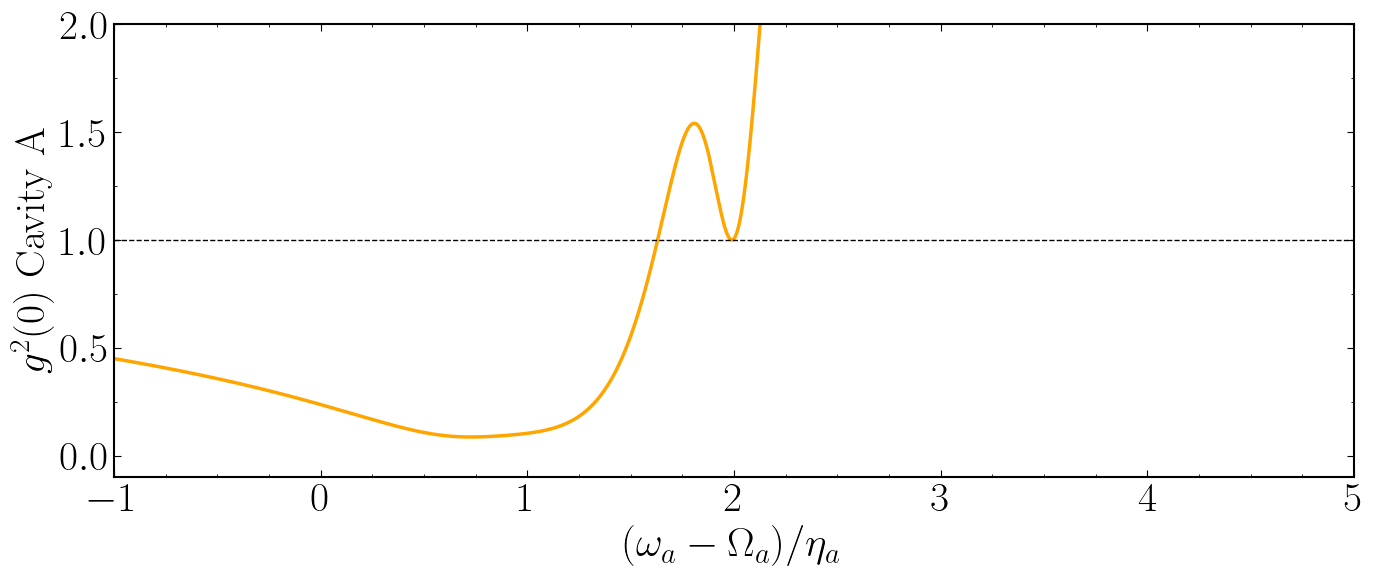

In [375]:
x_list = (w[0] - Omega_a_list) / (etaA)
y_list_1 = [(expect(a.dag()*a.dag()*a*a, i))/((expect(a.dag()*a, i))**2)  for i in results_at_t1]

fig, axes = plt.subplots(1, 1, figsize=(16, 6))

axes.plot(x_list, y_list_1, color = 'orange', linestyle='-', lw = lw)

axes.set_xlabel(r'$(\omega_a - \Omega_a)/\eta_a$', rotation=0, fontsize=fs)
axes.set_ylabel(r'$g^2(0)$ Cavity A', rotation=90, fontsize=fs)

axes.tick_params(axis='both', which='major', direction='in', labelsize=ls)
axes.tick_params(axis='both', which='minor', direction='in', labelsize=ls)
axes.yaxis.set_ticks_position('both')

axes.set_xlim(-1,5)
axes.set_ylim(-0.1,2)

start, end = axes.get_xlim()
axes.xaxis.set_ticks(arange(start, end+1, 1))
axes.hlines(1, start, end, color = 'black', linestyle='--', lw = 1)

axes.xaxis.set_ticks_position('both')
axes.yaxis.set_ticks_position('both')

axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.xaxis.set_minor_locator(AutoMinorLocator(4))

axes.xaxis.set_tick_params(length=5)
axes.yaxis.set_tick_params(length=5)

axes.margins(x=0.1, y=0.1)